# **EDA + DATACLEANING + VISUALIZATION**
---

**Objetivo**

En este notebook se analizará el dataset realizado por el CSSE de la Universidad Johns Hopkings para el estudio del COVID-19: https://github.com/CSSEGISandData/COVID-19 . Se trata de visualizar la incidencia del covid en el mundo.

Los datos han sido tomados desde el 21 de enero del 2020 hasta el 10 de marzo del 2023 y se pueden descargar desde los enlaces:
- Casos de contagios confirmados en el mundo:
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
- Casos de muertes por coronavirus en el mundo:
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv

Se meten ambos archivos dentro de la carpeta 'data'

In [49]:
# Sistema operativo
import os

# Asigno la ruta actual

os.chdir('D:\Data_Science\EDA_CLEANING_PREPROCCESING\Eda-DataCleaning-Visualization-COVID19\data') 
os.getcwd() 

'D:\\Data_Science\\EDA_CLEANING_PREPROCCESING\\Eda-DataCleaning-Visualization-COVID19\\data'

Podemos ver un dashboard con la situación del coronavirus: https://www.arcgis.com/apps/dashboards/bda7594740fd40299423467b48e9ecf6

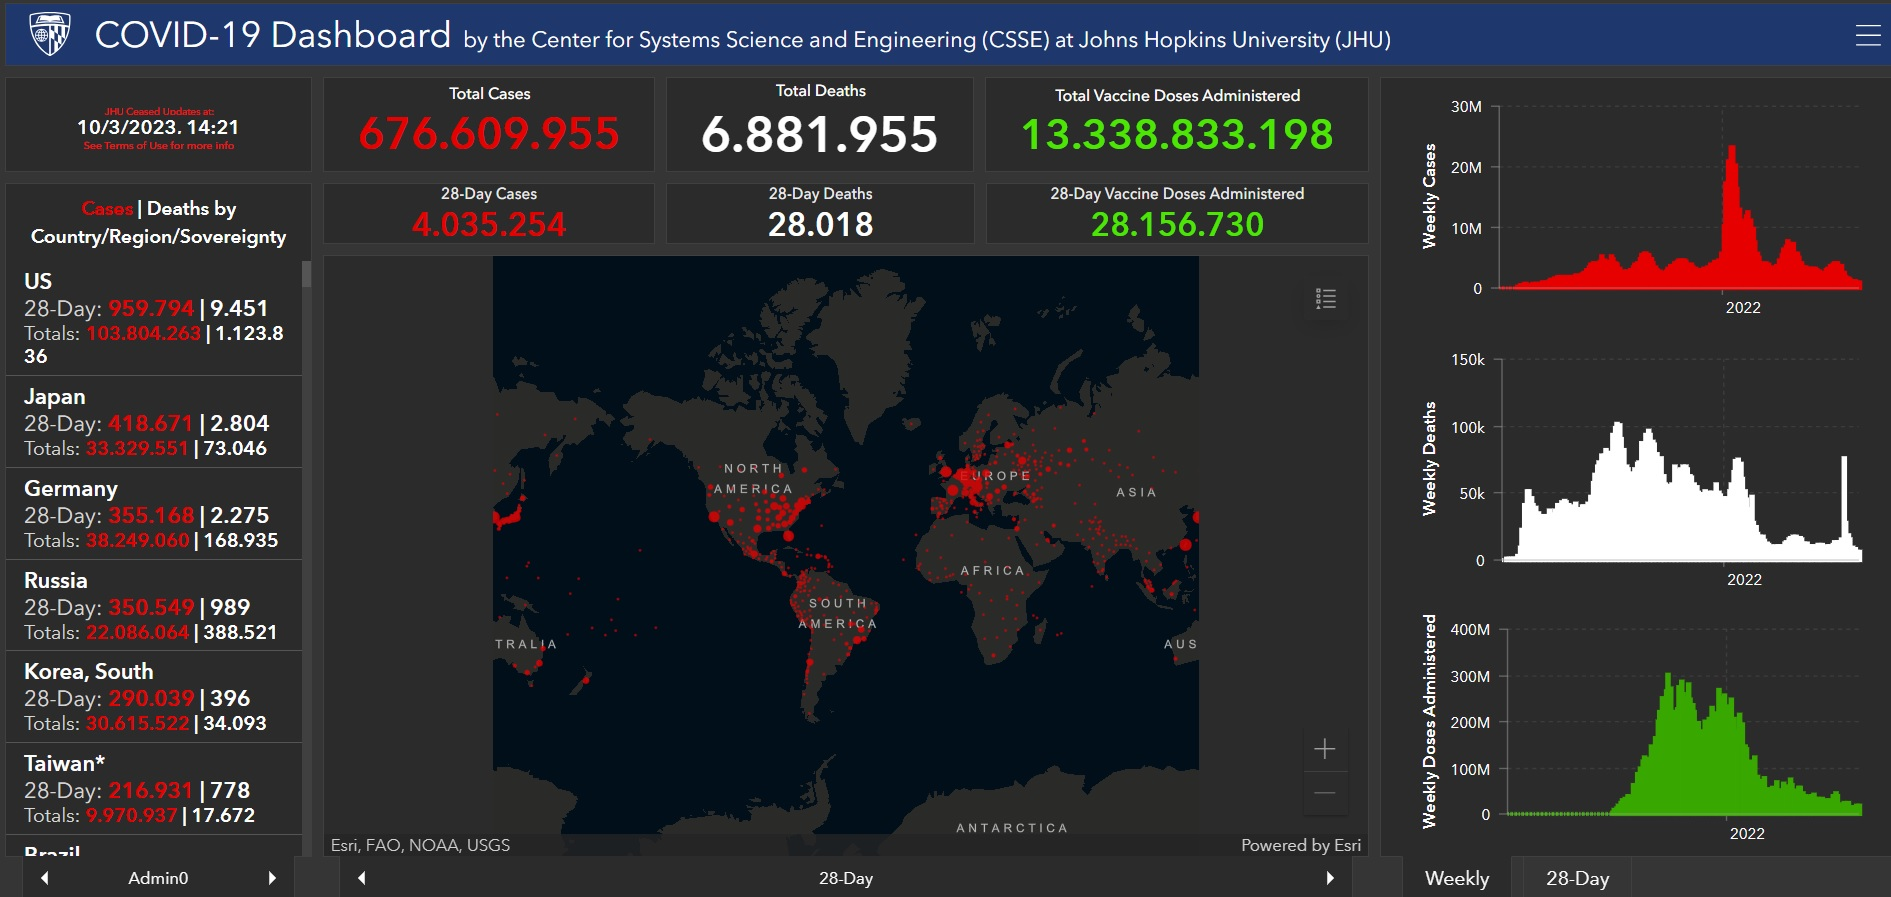

In [50]:
from IPython.display import Image
Image('Dashboard_Covid_19.jpg')

In [51]:
!pip install wget

In [52]:
!pip install calmap

In [53]:
!pip install plotly

In [54]:
!pip install folium

**Importo las librerías**

In [55]:
import time

# silence warnings
import warnings
warnings.filterwarnings("ignore")

# Descargas de archivos
import wget

# Pandas y Numpy
import numpy as np
import pandas as pd

# loading ploting libraries
import plotly.express as px

# Mapa iteractivo (por defecto OpenStreetMap)
import folium
import calmap

# Versiones de las librerías instaladas
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"Folium version {folium.__version__}")
print(f"Calmap version {calmap.__version__}")

# Config
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

Working with these versions of libraries

Numpy version 1.21.5
Pandas version 1.4.4
Folium version 0.14.0
Calmap version 0.0.9


**Clases y funciones**

In [56]:
# Elimina duplicados
def drop_duplicates (dataframe):
    '''
    Elimina filas duplicadas del dataset
    '''
    print(f"Shape antes: {dataframe.shape}")
    df_duplicated = dataframe[dataframe.duplicated(keep = False)]
    print(f"Se han eliminado {len(dataframe[dataframe.duplicated()])} registros repetidos")
    dataframe.drop_duplicates(inplace = True)

    if len(dataframe[dataframe.duplicated()])>0:
        print(f"Shape despues: {dataframe.shape}")
        return df_duplicated

**DataFrameReporter**
Nos va a permitir hacer un primer contacto con el dataset.\
Se trata de una clase auxiliar que hará una parte del **EDA**.

In [57]:
class DataFrameReporter(object):
    '''
    Helper class that reports nulls and datatypes of columns
    '''
    def __init__(self, df): # Variables que le tengo que suministrar a la clase
        '''
        Constructor for the class.
        Needs dataframe
        '''
        self.df = df
               
    def analyze_X(self, X):
        '''
        Analyses the DataFrame you pass and returns a report of nulls, distribution and other goodies.
        '''        
               
        dtypes = X.dtypes.to_frame().rename(columns = {0:"Dtypes"}) # Tipos de variables

        nulls_in_X = X.isnull().sum().to_frame().rename(columns = {0:"Absolute_nulls"}) # Número de nulos en las variables
        nulls_in_X["Relative_nulls"] = nulls_in_X["Absolute_nulls"]/X.shape[0]
        nulls_in_X["Relative_nulls"] = nulls_in_X["Relative_nulls"].apply(
            lambda number: round(number, 3) * 100 # Relative_nulls = (Absolute_nulls/Shape)*100 ... con 3 cifras significativas
        )
        
        nulls_in_X = pd.concat([nulls_in_X, dtypes], axis = 1)
        nulls_in_X["Shape"] = X.shape[0] # Número de registros
        nulls_in_X = nulls_in_X[["Dtypes", "Shape", "Absolute_nulls", "Relative_nulls"]] # Ordeno las columnas

         
        describe_values_num = X.describe().T # Describe de las variables numéricas
        report_df = pd.concat([nulls_in_X, describe_values_num], axis = 1)
               
        describe_values_cat = X.describe(exclude = "number").T # Describe de las variables categóricas
        report_df = pd.concat([report_df, describe_values_cat], axis = 1)

        report_df.fillna("", inplace = True) # Imputo los nulos con un vacío
        report_df.sort_values("Dtypes", ascending = True, inplace = True) # Ordeno las variables por tipos
        
        return report_df
        
    def get_reports(self):
        '''
        Calls analyze_X method and returns report DataFrame for train and test.
        '''
        report_df = self.analyze_X(X = self.df)
                
        return report_df

**Ruta del dataset**

In [58]:
#Si se usa Collab
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [59]:
ficheros=["time_series_covid19_confirmed_global.csv",
          "time_series_covid19_deaths_global.csv"]

In [60]:
# Elimino los ficheros en caso de que existan
for i in ficheros:
    if os.path.exists(i):
        os.remove(i)

In [61]:
# Descargo los ficheros y los guardo en el directorio actual
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv']
for url in urls:
    filename = wget.download(url, os.getcwd() )

## **1.- Data Loading**

In [62]:
infected = pd.read_csv('time_series_covid19_confirmed_global.csv')
infected.info()
infected.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 1147 entries, Province/State to 3/9/23
dtypes: float64(2), int64(1143), object(2)
memory usage: 2.5+ MB


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

In [63]:
# Últimos datos disponibles
infected.columns[-1:]

Index(['3/9/23'], dtype='object')

In [64]:
deceased = pd.read_csv('time_series_covid19_deaths_global.csv')
deceased.info()
deceased.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 1147 entries, Province/State to 3/9/23
dtypes: float64(2), int64(1143), object(2)
memory usage: 2.5+ MB


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

In [65]:
# Últimos datos disponibles
deceased.columns[-1:]

Index(['3/9/23'], dtype='object')

Para una mejor comprensión y visualización de los datos, debido a la cantidad de columnas que tienen los datasets, colocaremos las fechas en filas utilizando la función melt(). De esta forma pasaremos de un datset con formato ancho a uno con formato alto.

Melt() transforma un DataFrame con múltiples columnas en un DataFrame con menos columnas, donde una o más columnas son variables de identificación y el resto se fusionan en una sola variable y columnas de valor.

Con ello se formará un dataset de 6 columnas y 289*(1147-4) = 330.327 filas

In [66]:
infected_tras = pd.melt(frame = infected, id_vars= ['Province/State','Country/Region','Lat','Long'], 
        value_vars = infected.columns[4:], var_name = 'Date', value_name = 'Infected')
infected_tras.sample(5)

,Province/State,Country/Region,Lat,Long,Date,Infected
59391,NaN,Hungary,47.16,19.50,8/14/20,4853
59155,Sint Maarten,Netherlands,18.04,-63.05,8/13/20,263
35413,NaN,Jamaica,18.11,-77.30,5/23/20,550
244749,NaN,Tonga,-21.18,-175.20,5/17/22,11280
119846,NaN,Netherlands,52.13,5.29,3/11/21,1144822


In [67]:
deceased_tras = pd.melt(frame = deceased, id_vars= ['Province/State','Country/Region','Lat','Long'], 
        value_vars = infected.columns[5:], var_name = 'Date', value_name = 'Deaths')
deceased_tras.sample(5)

,Province/State,Country/Region,Lat,Long,Date,Deaths
265947,Hainan,China,19.20,109.75,7/31/22,6
251681,NaN,Tanzania,-6.37,34.89,6/11/22,840
117478,NaN,Holy See,41.90,12.45,3/4/21,0
143402,NaN,Chile,-35.68,-71.54,6/2/21,29385
253657,NaN,Nicaragua,12.87,-85.21,6/18/22,241


In [68]:
# Unimos ambos dataframes
covid19 = pd.merge(infected_tras,deceased_tras, how="inner",on=["Province/State", "Country/Region", "Date", "Lat", "Long"])
# Ordenamos las columnas
covid19 = covid19.reindex(["Date","Country/Region","Province/State","Lat","Long","Infected","Deaths"], axis=1)
covid19.head()

,Date,Country/Region,Province/State,Lat,Long,Infected,Deaths
0,1/23/20,Afghanistan,NaN,33.94,67.71,0,0
1,1/23/20,Albania,NaN,41.15,20.17,0,0
2,1/23/20,Algeria,NaN,28.03,1.66,0,0
3,1/23/20,Andorra,NaN,42.51,1.52,0,0
4,1/23/20,Angola,NaN,-11.20,17.87,0,0


## **2.- EDA: exploratory data analysis**

### 2.1.- ELIMINACIÓN DE FILAS REPETIDAS

In [69]:
drop_duplicates (dataframe = covid19)

Shape antes: (330038, 7)
Se han eliminado 0 registros repetidos


### 2.2.- ANÁLISIS UNIVARIANTE DE LOS DATOS

**A. Data Size**

In [70]:
# Tamaño del dataset
covid19.size

2310266

In [71]:
# Filas y columnas
covid19.shape

(330038, 7)

In [72]:
# Información resumida del dataset
covid19.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330038 entries, 0 to 330037
Columns: 7 entries, Date to Deaths
dtypes: float64(2), int64(2), object(3)
memory usage: 20.1+ MB


**B. Visualización directa de los datos**

In [73]:
# Cinco primeros registros
covid19.head()

,Date,Country/Region,Province/State,Lat,Long,Infected,Deaths
0,1/23/20,Afghanistan,NaN,33.94,67.71,0,0
1,1/23/20,Albania,NaN,41.15,20.17,0,0
2,1/23/20,Algeria,NaN,28.03,1.66,0,0
3,1/23/20,Andorra,NaN,42.51,1.52,0,0
4,1/23/20,Angola,NaN,-11.20,17.87,0,0


In [74]:
# Cinco registros aleatorios
covid19.sample(5)

,Date,Country/Region,Province/State,Lat,Long,Infected,Deaths
208676,1/14/22,Azerbaijan,NaN,40.14,47.58,624208,8497
49849,7/13/20,Guinea-Bissau,NaN,11.80,-15.18,1842,26
13928,3/11/20,Central African Republic,NaN,6.61,20.94,0,0
259411,7/8/22,Malaysia,NaN,4.21,101.98,4589911,35801
178612,10/2/21,Australia,New South Wales,-33.87,151.21,64668,426


In [75]:
# Cinco últimos registros
covid19.tail()

,Date,Country/Region,Province/State,Lat,Long,Infected,Deaths
330033,3/9/23,West Bank and Gaza,NaN,31.95,35.23,703228,5708
330034,3/9/23,Winter Olympics 2022,NaN,39.90,116.41,535,0
330035,3/9/23,Yemen,NaN,15.55,48.52,11945,2159
330036,3/9/23,Zambia,NaN,-13.13,27.85,343135,4057
330037,3/9/23,Zimbabwe,NaN,-19.02,29.15,264276,5671


**C. Tipos de atributos disponibles**

**Descripción general**

In [76]:
covid19.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330038 entries, 0 to 330037
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            330038 non-null  object 
 1   Country/Region  330038 non-null  object 
 2   Province/State  103922 non-null  object 
 3   Lat             327754 non-null  float64
 4   Long            327754 non-null  float64
 5   Infected        330038 non-null  int64  
 6   Deaths          330038 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 20.1+ MB


In [77]:
report_covid19 = DataFrameReporter(df = covid19).get_reports()
report_covid19

,Dtypes,Shape,Absolute_nulls,Relative_nulls,count,mean,std,min,25%,50%,75%,max,count,unique,top,freq
Infected,int64,330038,0,0.00,"330,038.00","960,223.66","4,868,080.72",0.00,686.00,"14,501.00","228,863.25","103,802,702.00",,,,
Deaths,int64,330038,0,0.00,"330,038.00","13,391.84","63,918.63",0.00,3.00,151.00,"3,039.00","1,123,836.00",,,,
Lat,float64,330038,2284,0.70,"327,754.00",19.72,25.91,-71.95,3.93,21.51,40.46,71.71,,,,
Long,float64,330038,2284,0.70,"327,754.00",22.18,77.74,-178.12,-42.60,20.94,90.36,178.06,,,,
Date,object,330038,0,0.00,,,,,,,,,330038,1142,1/23/20,289
Country/Region,object,330038,0,0.00,,,,,,,,,330038,201,China,38828
Province/State,object,330038,226116,68.50,,,,,,,,,103922,91,Australian Capital Territory,1142


De un primer análisis se sacan las siguientes conclusiones:
- Hay nulos en 'Province/State', 'Lat' y 'Long'
- El 70% de los datos de 'Province/State' son nulos. Candidata a ser eliminada
- 'Date' está como object, por lo habrá que pasarla a datetime

**Fechas**

In [78]:
covid19['Date'] = pd.to_datetime(covid19['Date'], errors = 'coerce')

### 2.3.- TRATAMIENTO DE LOS NULOS

**Province/State**

Compruebo que en los datos no hay ningún pais infiltrado

In [79]:
covid19['Province/State'].value_counts()

Australian Capital Territory                    1142
Saint Pierre and Miquelon                       1142
Reunion                                         1142
New Caledonia                                   1142
Mayotte                                         1142
Martinique                                      1142
Guadeloupe                                      1142
French Polynesia                                1142
French Guiana                                   1142
Greenland                                       1142
Faroe Islands                                   1142
Zhejiang                                        1142
Yunnan                                          1142
Xinjiang                                        1142
Unknown                                         1142
Tibet                                           1142
Tianjin                                         1142
Sichuan                                         1142
Shanxi                                        

Compruebo si en los registros en los que hay nulos en 'Province/State', también hay en 'Lat' o en 'Long'. Aquellos registros que también tengan nulos en la latitud o longitud, no los podré ubicar en un mapa.

In [80]:
covid19[(covid19['Province/State'].isnull()) & ((covid19['Lat'].isnull()) | (covid19['Long'].isnull()))]

,Date,Country/Region,Province/State,Lat,Long,Infected,Deaths


No más nulos en los registros, por lo que no puedo eliminar la columna 'Province/State', ya que aunque no conozca el nombre de la provincia, sí conozco dónde está ubicado.

Pondré un nombre cualquiera a los nulos de 'Province/State'

In [81]:
covid19['Province/State'].fillna('SinNombre', inplace = True)

**Lat y Long**

In [82]:
# Compruebo que se tratan de los mismos nulos
(covid19['Lat'].isnull() == covid19['Long'].isnull()).value_counts()

True    330038
dtype: int64

In [83]:
# Todos los nulos son de Canadá y China
covid19[covid19['Lat'].isnull()]['Country/Region'].value_counts()

Canada    1142
China     1142
Name: Country/Region, dtype: int64

In [84]:
# Todos los nulos son Repatriated Travellers
covid19[(covid19['Country/Region']=='Canada') & (covid19['Lat'].isnull())]['Province/State'].value_counts()

Repatriated Travellers    1142
Name: Province/State, dtype: int64

In [85]:
# Todos los nulos son de ubicación desconocida
covid19[(covid19['Country/Region']=='China') & (covid19['Lat'].isnull())]['Province/State'].value_counts()

Unknown    1142
Name: Province/State, dtype: int64

Todos los nulos se rellenan con datos obtenidos de la página: https://www.geodatos.net/

In [86]:
for n in ['China', 'Canada']:
    if n=='China':
        for i in ['Lat', 'Long']:
            if i=='Lat':
                covid19[i] = np.where((covid19['Country/Region']==n) & (covid19[i].isnull()), 35.86166, covid19[i])
            else:
                covid19[i] = np.where((covid19['Country/Region']==n) & (covid19[i].isnull()), 104.195397, covid19[i])
    
    else:
        for i in ['Lat', 'Long']:
            if i=='Lat':
                covid19[i] = np.where((covid19['Country/Region']==n) & (covid19[i].isnull()), 56.130366, covid19[i])
            else:
                covid19[i] = np.where((covid19['Country/Region']==n) & (covid19[i].isnull()), -106.346771, covid19[i])

In [87]:
covid19.isnull().sum()

Date              0
Country/Region    0
Province/State    0
Lat               0
Long              0
Infected          0
Deaths            0
dtype: int64

## **3.- VISUALIZACIONES**

Añadimos una columna para tener el número de casos de contagio que no han fallecido

In [88]:
covid19['Infected_NoDeath'] = covid19['Infected']-covid19['Deaths']

In [89]:
covid19[covid19['Country/Region']=='Spain'].tail()

,Date,Country/Region,Province/State,Lat,Long,Infected,Deaths,Infected_NoDeath
328834,2023-03-05,Spain,SinNombre,40.46,-3.75,13770429,119479,13650950
329123,2023-03-06,Spain,SinNombre,40.46,-3.75,13770429,119479,13650950
329412,2023-03-07,Spain,SinNombre,40.46,-3.75,13770429,119479,13650950
329701,2023-03-08,Spain,SinNombre,40.46,-3.75,13770429,119479,13650950
329990,2023-03-09,Spain,SinNombre,40.46,-3.75,13770429,119479,13650950


In [90]:
# Última fecha con registros de covid
covid19_date_max = covid19[covid19['Date']==covid19['Date'].max()]
covid19_date_max

,Date,Country/Region,Province/State,Lat,Long,Infected,Deaths,Infected_NoDeath
329749,2023-03-09,Afghanistan,SinNombre,33.94,67.71,209451,7896,201555
329750,2023-03-09,Albania,SinNombre,41.15,20.17,334457,3598,330859
329751,2023-03-09,Algeria,SinNombre,28.03,1.66,271496,6881,264615
329752,2023-03-09,Andorra,SinNombre,42.51,1.52,47890,165,47725
329753,2023-03-09,Angola,SinNombre,-11.20,17.87,105288,1933,103355
...,...,...,...,...,...,...,...,...
330033,2023-03-09,West Bank and Gaza,SinNombre,31.95,35.23,703228,5708,697520
330034,2023-03-09,Winter Olympics 2022,SinNombre,39.90,116.41,535,0,535
330035,2023-03-09,Yemen,SinNombre,15.55,48.52,11945,2159,9786
330036,2023-03-09,Zambia,SinNombre,-13.13,27.85,343135,4057,339078


### 3.1.- Visualización de paises con casos confirmados

In [91]:
# agrupo por paises
covid19_country = covid19_date_max.groupby('Country/Region')['Infected', 'Deaths', 'Infected_NoDeath'].sum().reset_index()
covid19_country.head()

,Country/Region,Infected,Deaths,Infected_NoDeath
0,Afghanistan,209451,7896,201555
1,Albania,334457,3598,330859
2,Algeria,271496,6881,264615
3,Andorra,47890,165,47725
4,Angola,105288,1933,103355


Documentación: https://plotly.github.io/plotly.py-docs/generated/plotly.express.choropleth.html

In [92]:
country_map = px.choropleth(
    data_frame = covid19_country, 
    locations='Country/Region', 
    locationmode='country names', 
    color='Infected', 
    hover_name='Country/Region', 
    range_color=[1,1e7],
    color_continuous_scale=['Green','Yellow','Red'], 
    title='Paises con casos de coronavirus')

country_map.show()

### 3.2.- Visualización de paises con todos los datos

In [93]:
covid19_date_max.head()

,Date,Country/Region,Province/State,Lat,Long,Infected,Deaths,Infected_NoDeath
329749,2023-03-09,Afghanistan,SinNombre,33.94,67.71,209451,7896,201555
329750,2023-03-09,Albania,SinNombre,41.15,20.17,334457,3598,330859
329751,2023-03-09,Algeria,SinNombre,28.03,1.66,271496,6881,264615
329752,2023-03-09,Andorra,SinNombre,42.51,1.52,47890,165,47725
329753,2023-03-09,Angola,SinNombre,-11.20,17.87,105288,1933,103355


In [94]:
# Elejimos el mapa a usar
global_map = folium.Map(
    location=[30, 10], # Coordenadas del centro del gobal_map
    tiles='cartodbpositron', # tipo de mapa que utilizamos
    #min_zoom=4, 
    #max_zoom=8, 
    zoom_start=2)

In [95]:
# Agregamos el mapa_global
for i in range(0, len(covid19_date_max)):
    folium.Circle(
        location=[covid19_date_max.iloc[i]['Lat'], covid19_date_max.iloc[i]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Country : '+str(covid19_date_max.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(covid19_date_max.iloc[i]['Province/State'])+
                    '<li><bold>Confirmed : '+str(covid19_date_max.iloc[i]['Infected'])+
                    '<li><bold>Deaths : '+str(covid19_date_max.iloc[i]['Deaths'])+
                    '<li><bold>Deaths : '+str(covid19_date_max.iloc[i]['Infected_NoDeath']),
        radius=int(covid19_date_max.iloc[i]['Infected'])**0.75).add_to(global_map)

global_map